In [1]:
import xarray as xr
import ghibtools as gh
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin
# from compute_rri import ecg_job
# from compute_resp_features import respiration_features_job
# from compute_eda import eda_job
# from compute_bandpower import bandpower_job
# from compute_power_at_resp import power_at_resp_job
# from compute_psycho import relaxation_job

from compute_global_dataframes import hrv_concat_job, resp_features_concat_job, eda_concat_job, bandpower_concat_job, power_at_resp_concat_job, relaxation_concat_job, rsa_concat_job, modulation_cycle_signal_concat_job

from params import *
from bibliotheque import get_pos
import physio
from configuration import base_folder
import os

In [2]:
metrics = {
    'hrv':['HRV_Mean', 'HRV_SD', 'HRV_Median', 'HRV_Mad','HRV_CV', 'HRV_MCV', 'HRV_RMSSD'],
    'eda':['Tonic', 'N_SCR', 'SCR_Height','SCR_Amplitude', 'SCR_RiseTime', 'SCR_RecoveryTime'],
    'resp':['cycle_duration', 'inspi_duration', 'expi_duration', 'cycle_freq',
       'cycle_ratio', 'inspi_volume', 'expi_volume', 'total_amplitude',
       'inspi_amplitude', 'expi_amplitude', 'total_volume'],
    'bandpower':['alpha power','theta power'],
    'power_at_resp':['max_eeg'],
    'rsa':['rising_amplitude','decay_amplitude'],
    'psycho':['Relaxation','Arousal','Relaxation_intensity'],
    'modulation':['amplitude']
}

In [3]:
def reorder_df(df, order_participants = subject_keys, order_session = session_keys):
    concat = []
    for sub in order_participants:
        for ses in order_session:
            concat.append(df[(df['participant'] == sub) & (df['session'] == ses)])
    return pd.concat(concat)

In [4]:
def get_hrv(run_keys):
    df = hrv_concat_job.get(global_key).to_dataframe()
    return reorder_df(df).groupby(['participant','session']).median(numeric_only = True).reset_index()

In [5]:
def get_eda(run_keys):
    df = eda_concat_job.get(global_key).to_dataframe()
    return reorder_df(df).groupby(['participant','session']).median(numeric_only = True).reset_index()

In [6]:
def get_power_at_resp(run_keys):
    df = power_at_resp_concat_job.get(global_key).to_dataframe()
    return reorder_df(df).groupby(['participant','session']).median(numeric_only = True).reset_index()

In [7]:
def get_bandpower(run_keys, loca = 'F'):
    bandpower = bandpower_concat_job.get(global_key).to_dataframe()
    bandpower_chans = bandpower[bandpower['chan'].isin([chan for chan in bandpower['chan'].unique() if loca in chan])]
    bandpower_alpha = bandpower_chans[bandpower_chans['band'] == 'alpha']
    bandpower_theta = bandpower_chans[bandpower_chans['band'] == 'theta']
    reorder_alpha = reorder_df(bandpower_alpha)
    reorder_alpha = reorder_alpha.set_index(['participant','chan','session']).rename(columns = {'power_integral':'alpha power'})
    reorder_theta = reorder_df(bandpower_theta)
    reorder_theta = reorder_theta.set_index(['participant','chan','session']).rename(columns = {'power_integral':'theta power'})
    df_return = pd.concat([reorder_alpha.reset_index(drop = True), reorder_theta.reset_index(drop = True)], axis = 1)
    return df_return[['alpha power','theta power']].set_index(reorder_theta.index).groupby(['participant','session']).mean(True).reset_index()

In [8]:
def get_resp_features(run_keys):
    df = resp_features_concat_job.get(global_key).to_dataframe()
    return reorder_df(df).groupby(['participant','session']).median(numeric_only = True).reset_index()

In [9]:
def get_rsa():
    df = rsa_concat_job.get(global_key).to_dataframe()
    return reorder_df(df).groupby(['participant','session']).median(numeric_only = True).reset_index()

In [10]:
def get_psycho():
    metrics = ['Arousal','Relaxation','Relaxation_intensity','Perceived_duration']
    indexes = ['participant','session']
    df = relaxation_concat_job.get(global_key).to_dataframe().reset_index(drop = True)
    df = df.drop(columns = ['stim_name'])
    df[metrics] = df[metrics].astype(float)
    return reorder_df(df)

In [11]:
def get_modulation():
    metrics = ['amplitude']
    indexes = ['participant','session']
    df = modulation_cycle_signal_concat_job.get(global_key).to_dataframe().reset_index(drop = True)
    df = df.groupby(['participant','session']).median(numeric_only = True).reset_index()
    df[metrics] = df[metrics].astype(float)
    return reorder_df(df)

In [12]:
psycho = get_psycho()

In [13]:
hrv = get_hrv(run_keys)

In [14]:
eda = get_eda(run_keys)

In [15]:
resp = get_resp_features(run_keys)

In [16]:
bandpower = get_bandpower(run_keys)

In [17]:
power_at_resp = get_power_at_resp(run_keys)

In [18]:
rsa = get_rsa()

In [19]:
modulation = get_modulation()

In [20]:
concat = []

for label, df in zip(['hrv','eda','resp','bandpower','power_at_resp','rsa','psycho','modulation'],[hrv, eda, resp, bandpower, power_at_resp, rsa, psycho, modulation]):
    concat.append(df[metrics[label]].reset_index(drop=True))
    
grouping = pd.concat(concat, axis = 1)

In [21]:
grouping = grouping.rename(columns = {'max_eeg':'power at resp'})

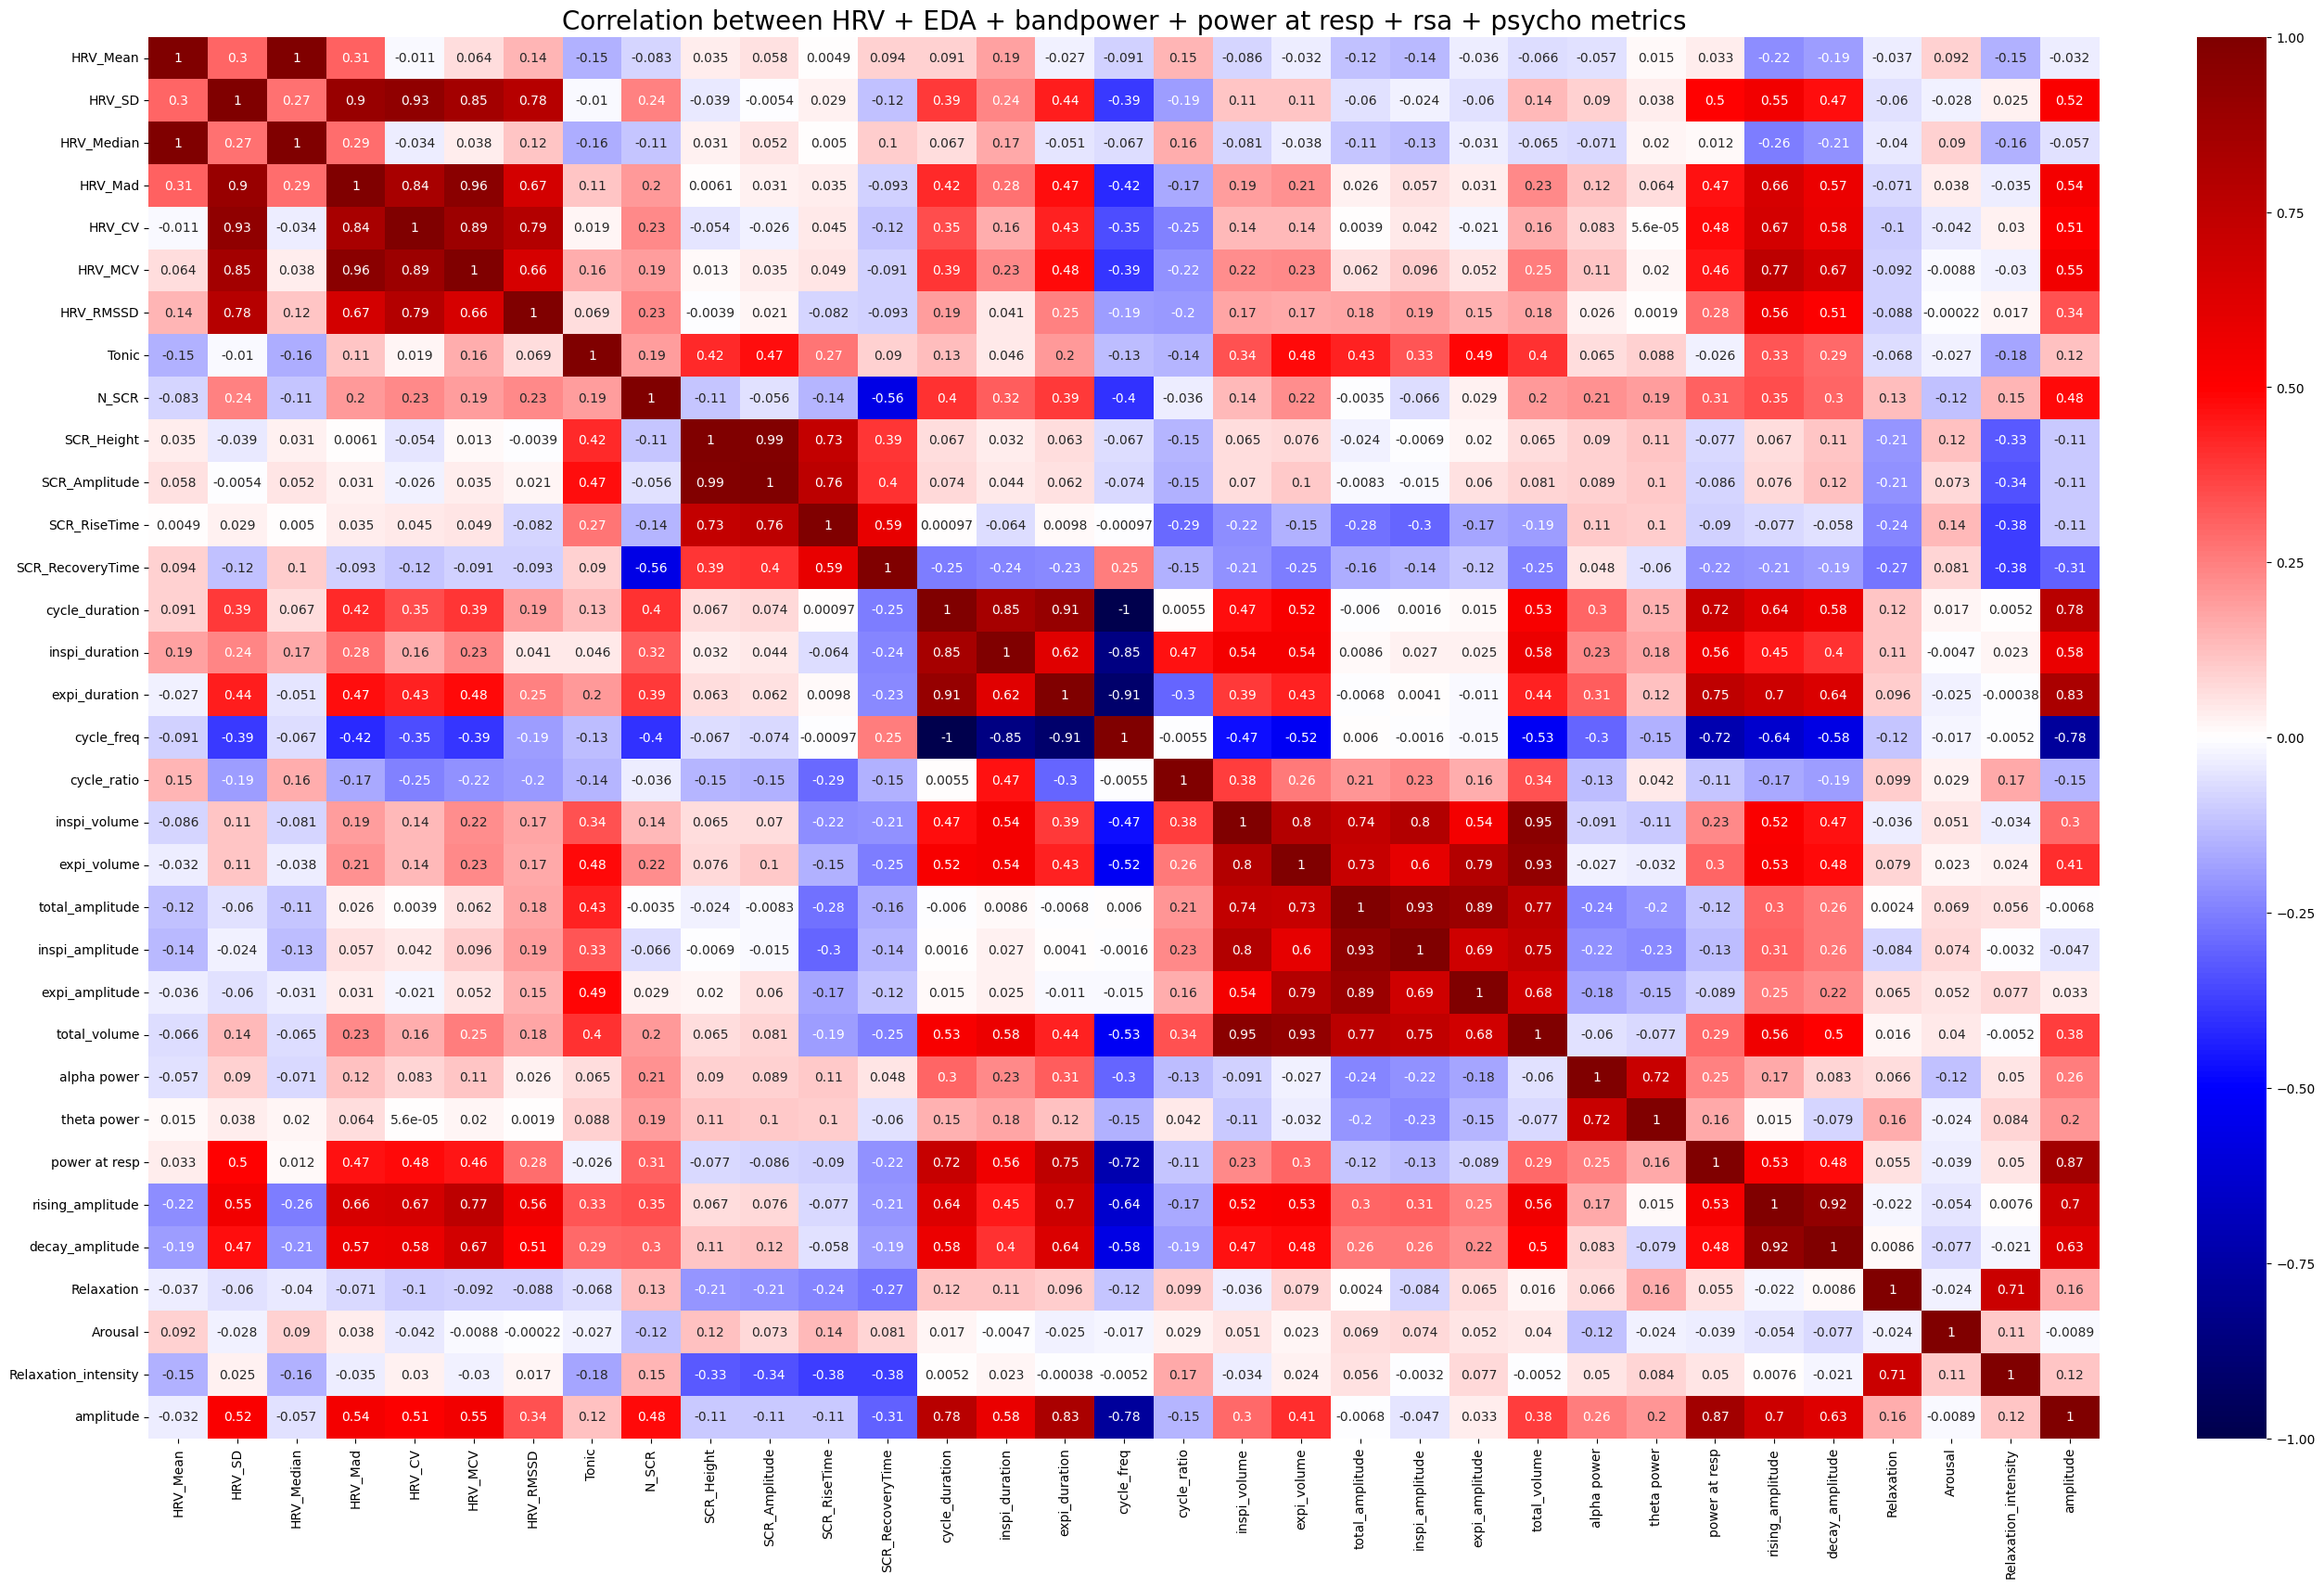

In [22]:
fig, ax = plt.subplots(figsize =(25, 17), constrained_layout = True)
sns.heatmap(grouping.corr('spearman'), annot = True, vmin = -1, vmax = 1, cmap = 'seismic',ax=ax)
ax.set_title('Correlation between HRV + EDA + bandpower + power at resp + rsa + psycho metrics', fontsize = 20)
file = base_folder / 'Figures' / 'Correlations' / 'big_correlation.png'
fig.savefig(file, bbox_inches = 'tight')

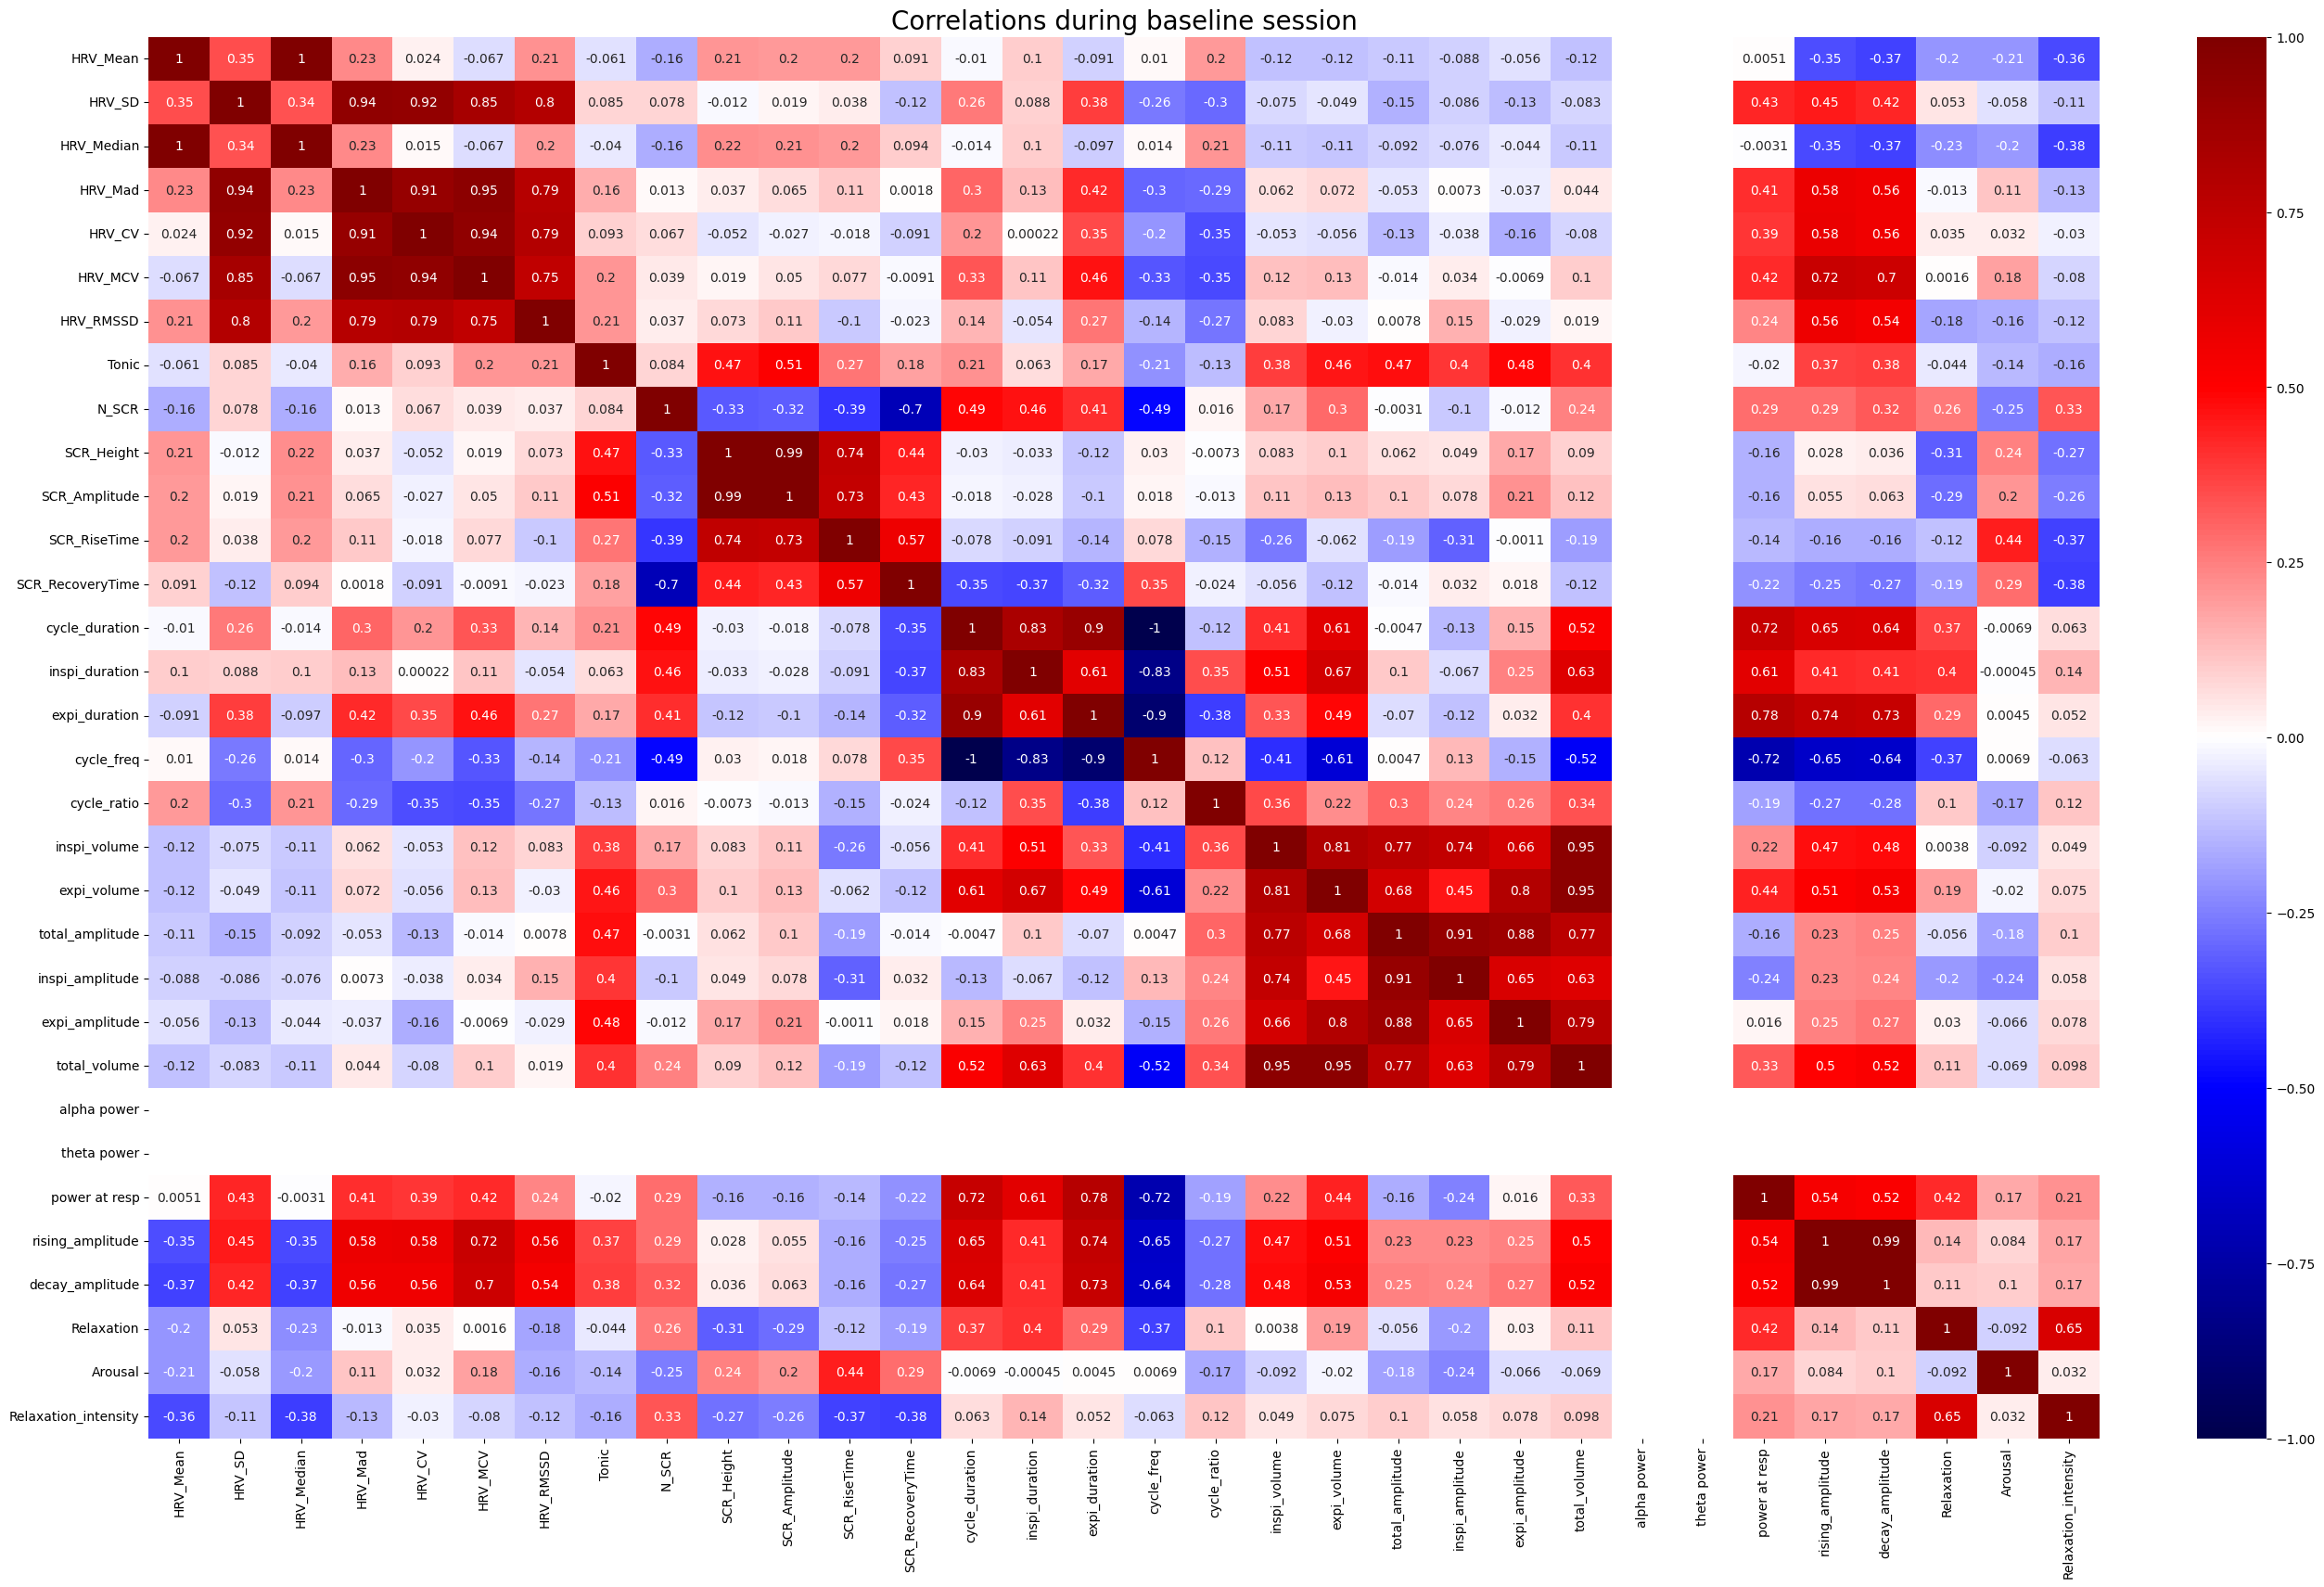

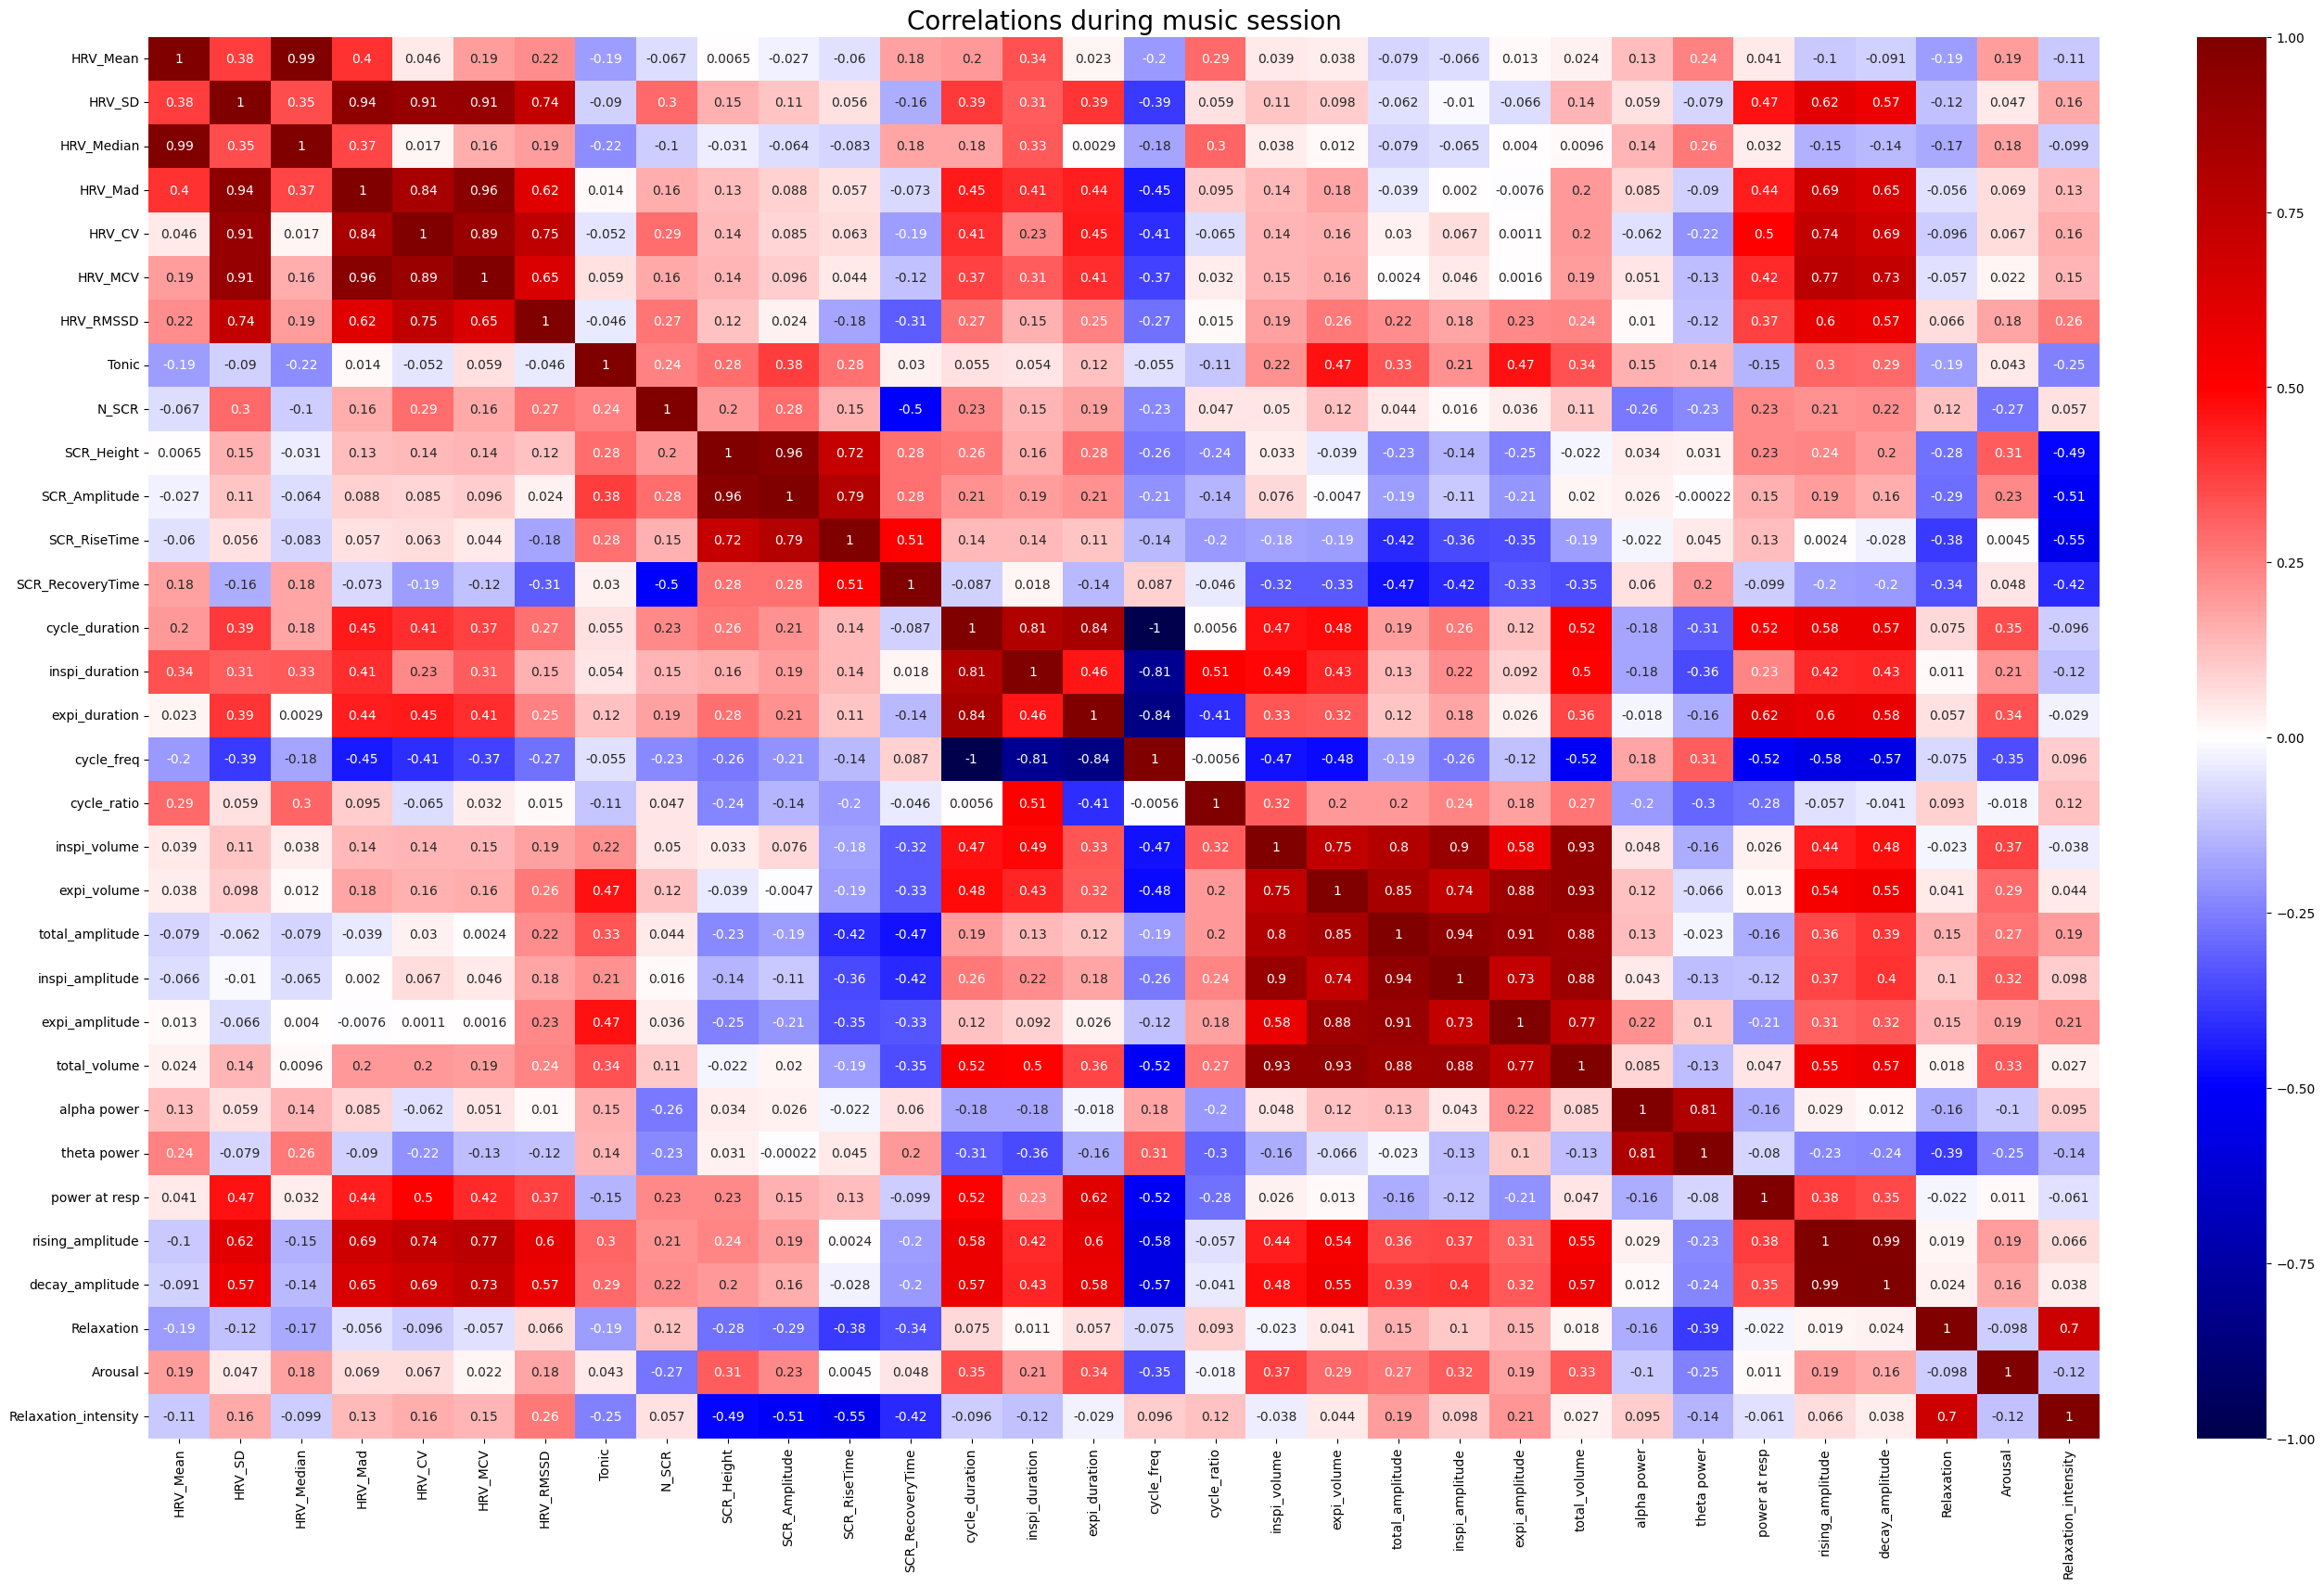

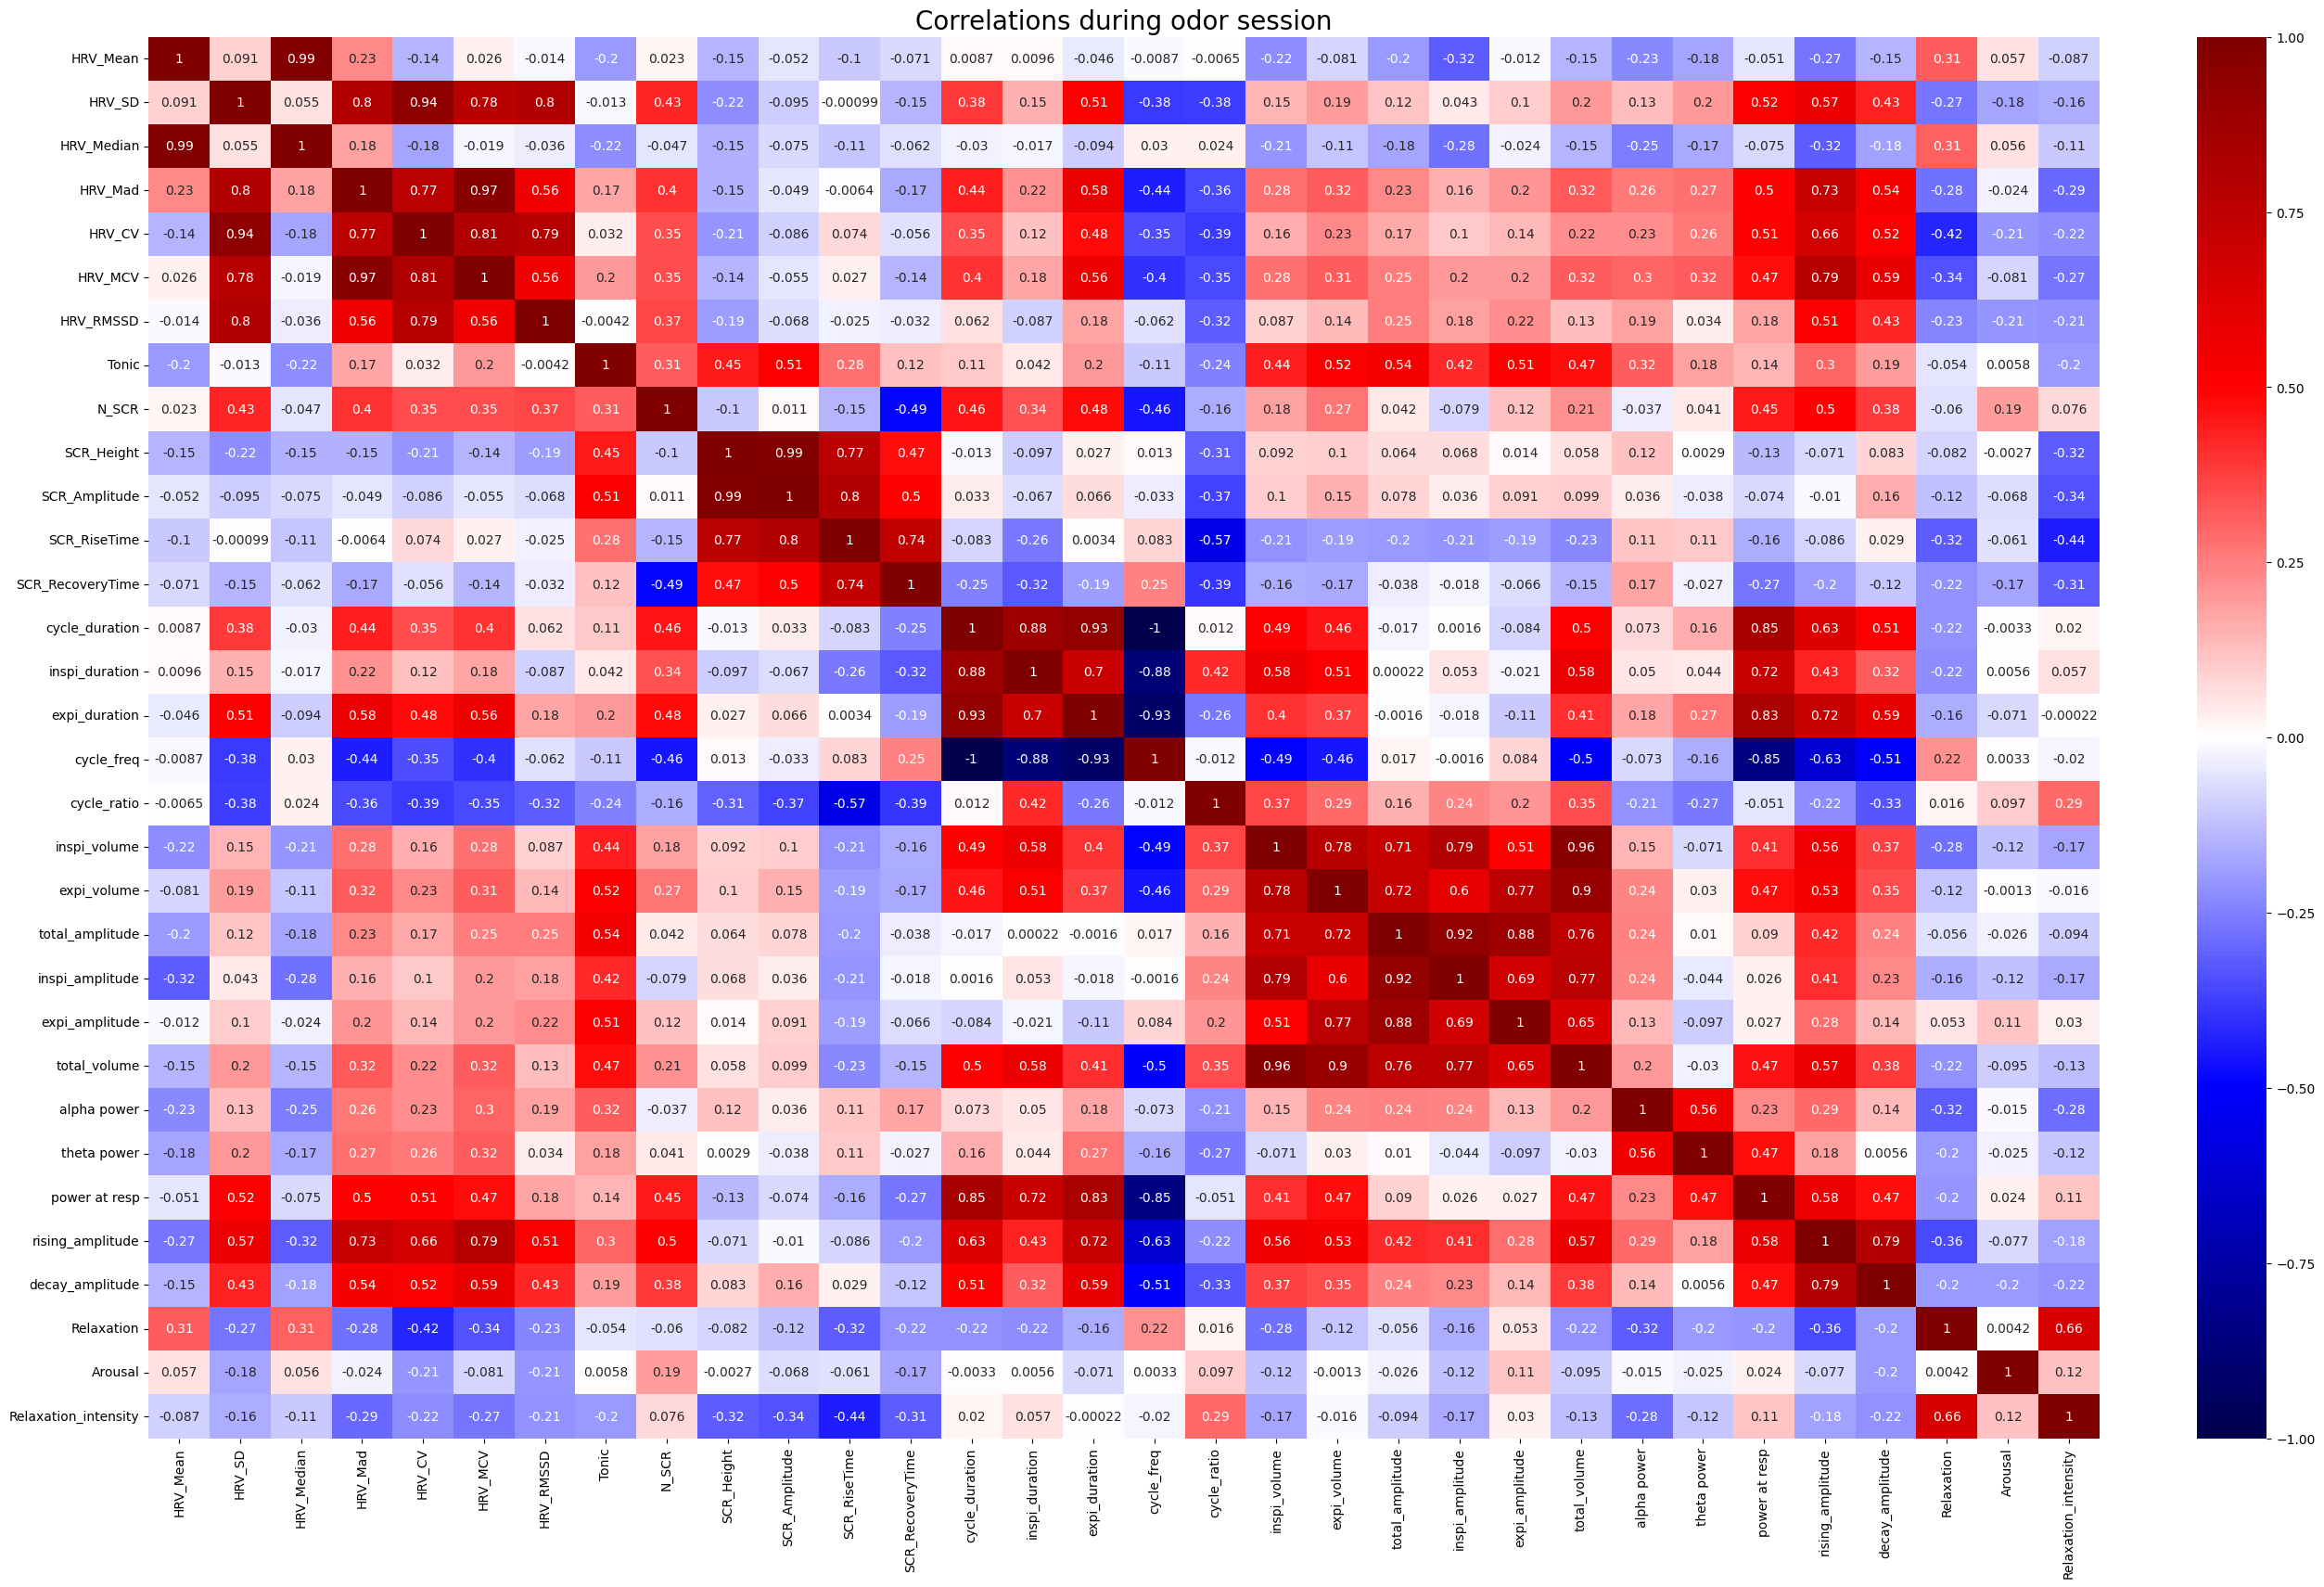

In [23]:
corrs = {}
for ses in session_keys:
    concat = []
    for label, df in zip(['hrv','eda','resp','bandpower','power_at_resp','rsa', 'psycho'],[hrv, eda, resp, bandpower, power_at_resp, rsa, psycho]):
        df_ses = df[df['session'] == ses][metrics[label]]
        concat.append(df_ses.reset_index(drop=True))
    grouping = pd.concat(concat, axis = 1)
    grouping = grouping.rename(columns = {'max_eeg':'power at resp'})
    fig, ax = plt.subplots(figsize =(25, 17), constrained_layout = True)
    corr = grouping.corr('spearman')
    corrs[ses] = corr
    sns.heatmap(corr, annot = True, vmin = -1, vmax = 1, cmap = 'seismic',ax=ax)
    ax.set_title(f'Correlations during {ses} session', fontsize = 20)
    file = base_folder / 'Figures' / 'Correlations' / f'big_correlation_{ses}.png'
    fig.savefig(file, bbox_inches = 'tight')

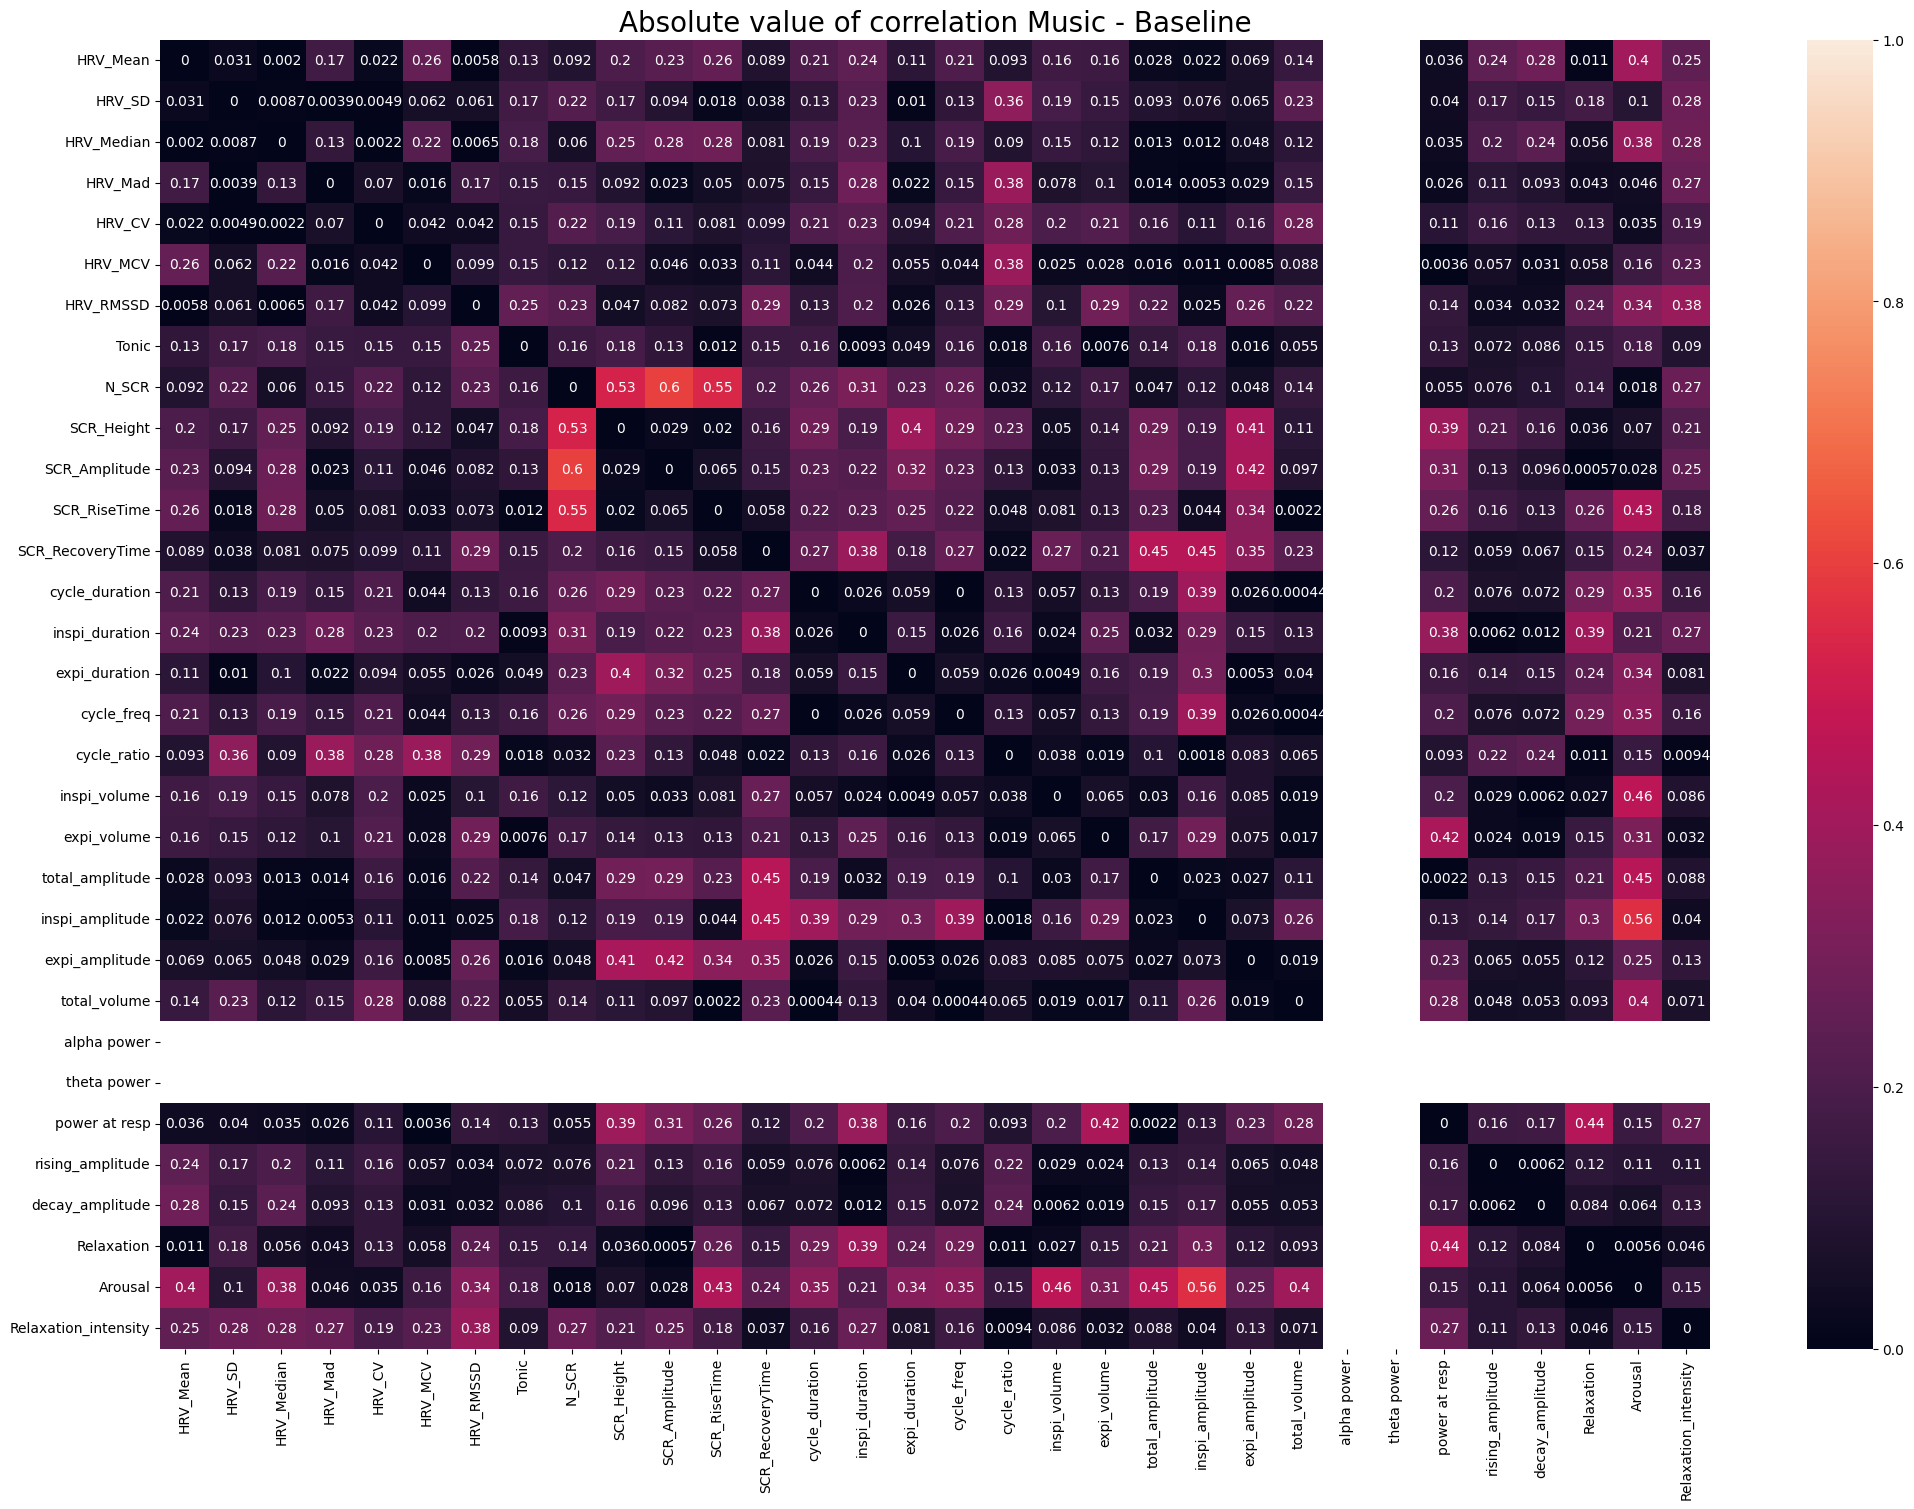

In [24]:
fig, ax = plt.subplots(figsize = (25,17))
sns.heatmap(np.abs(corrs['music'] - corrs['baseline']), annot = True, vmin = 0, vmax = 1, ax=ax)
ax.set_title(f'Absolute value of correlation Music - Baseline', fontsize = 20)
file = base_folder / 'Figures' /'Correlations' / f'big_correlation_abs_music_minus_baseline.png'
fig.savefig(file, bbox_inches = 'tight')

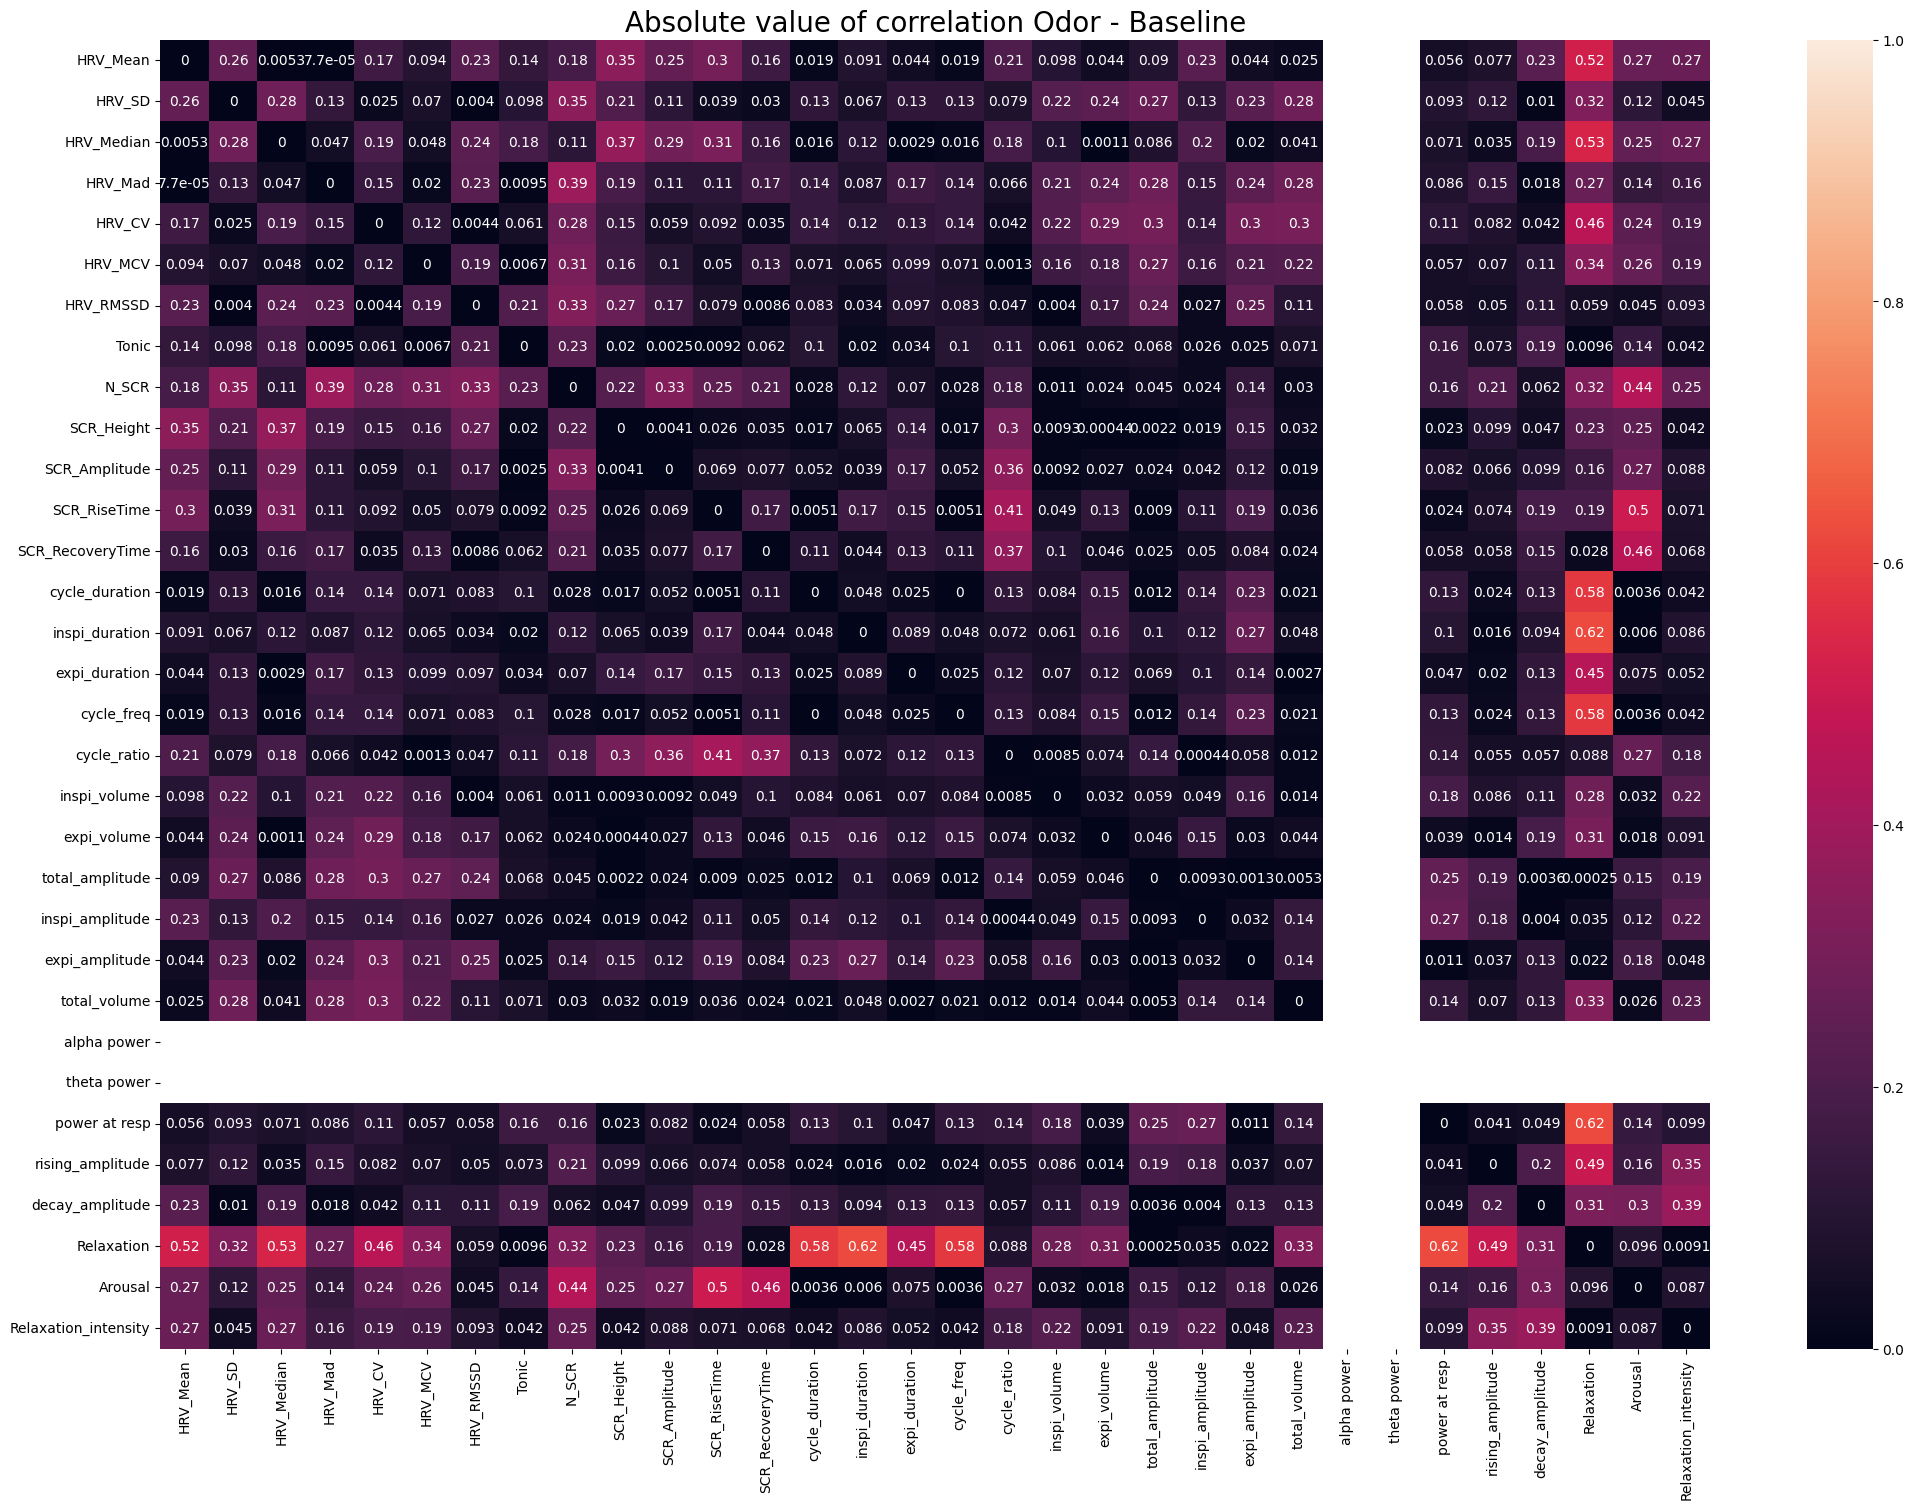

In [25]:
fig, ax = plt.subplots(figsize = (25,17))
sns.heatmap(np.abs(corrs['odor'] - corrs['baseline']), annot = True, vmin = 0, vmax = 1, ax=ax)
ax.set_title(f'Absolute value of correlation Odor - Baseline', fontsize = 20)
file = base_folder / 'Figures' /'Correlations' / f'big_correlation_abs_odor_minus_baseline.png'
fig.savefig(file, bbox_inches = 'tight')

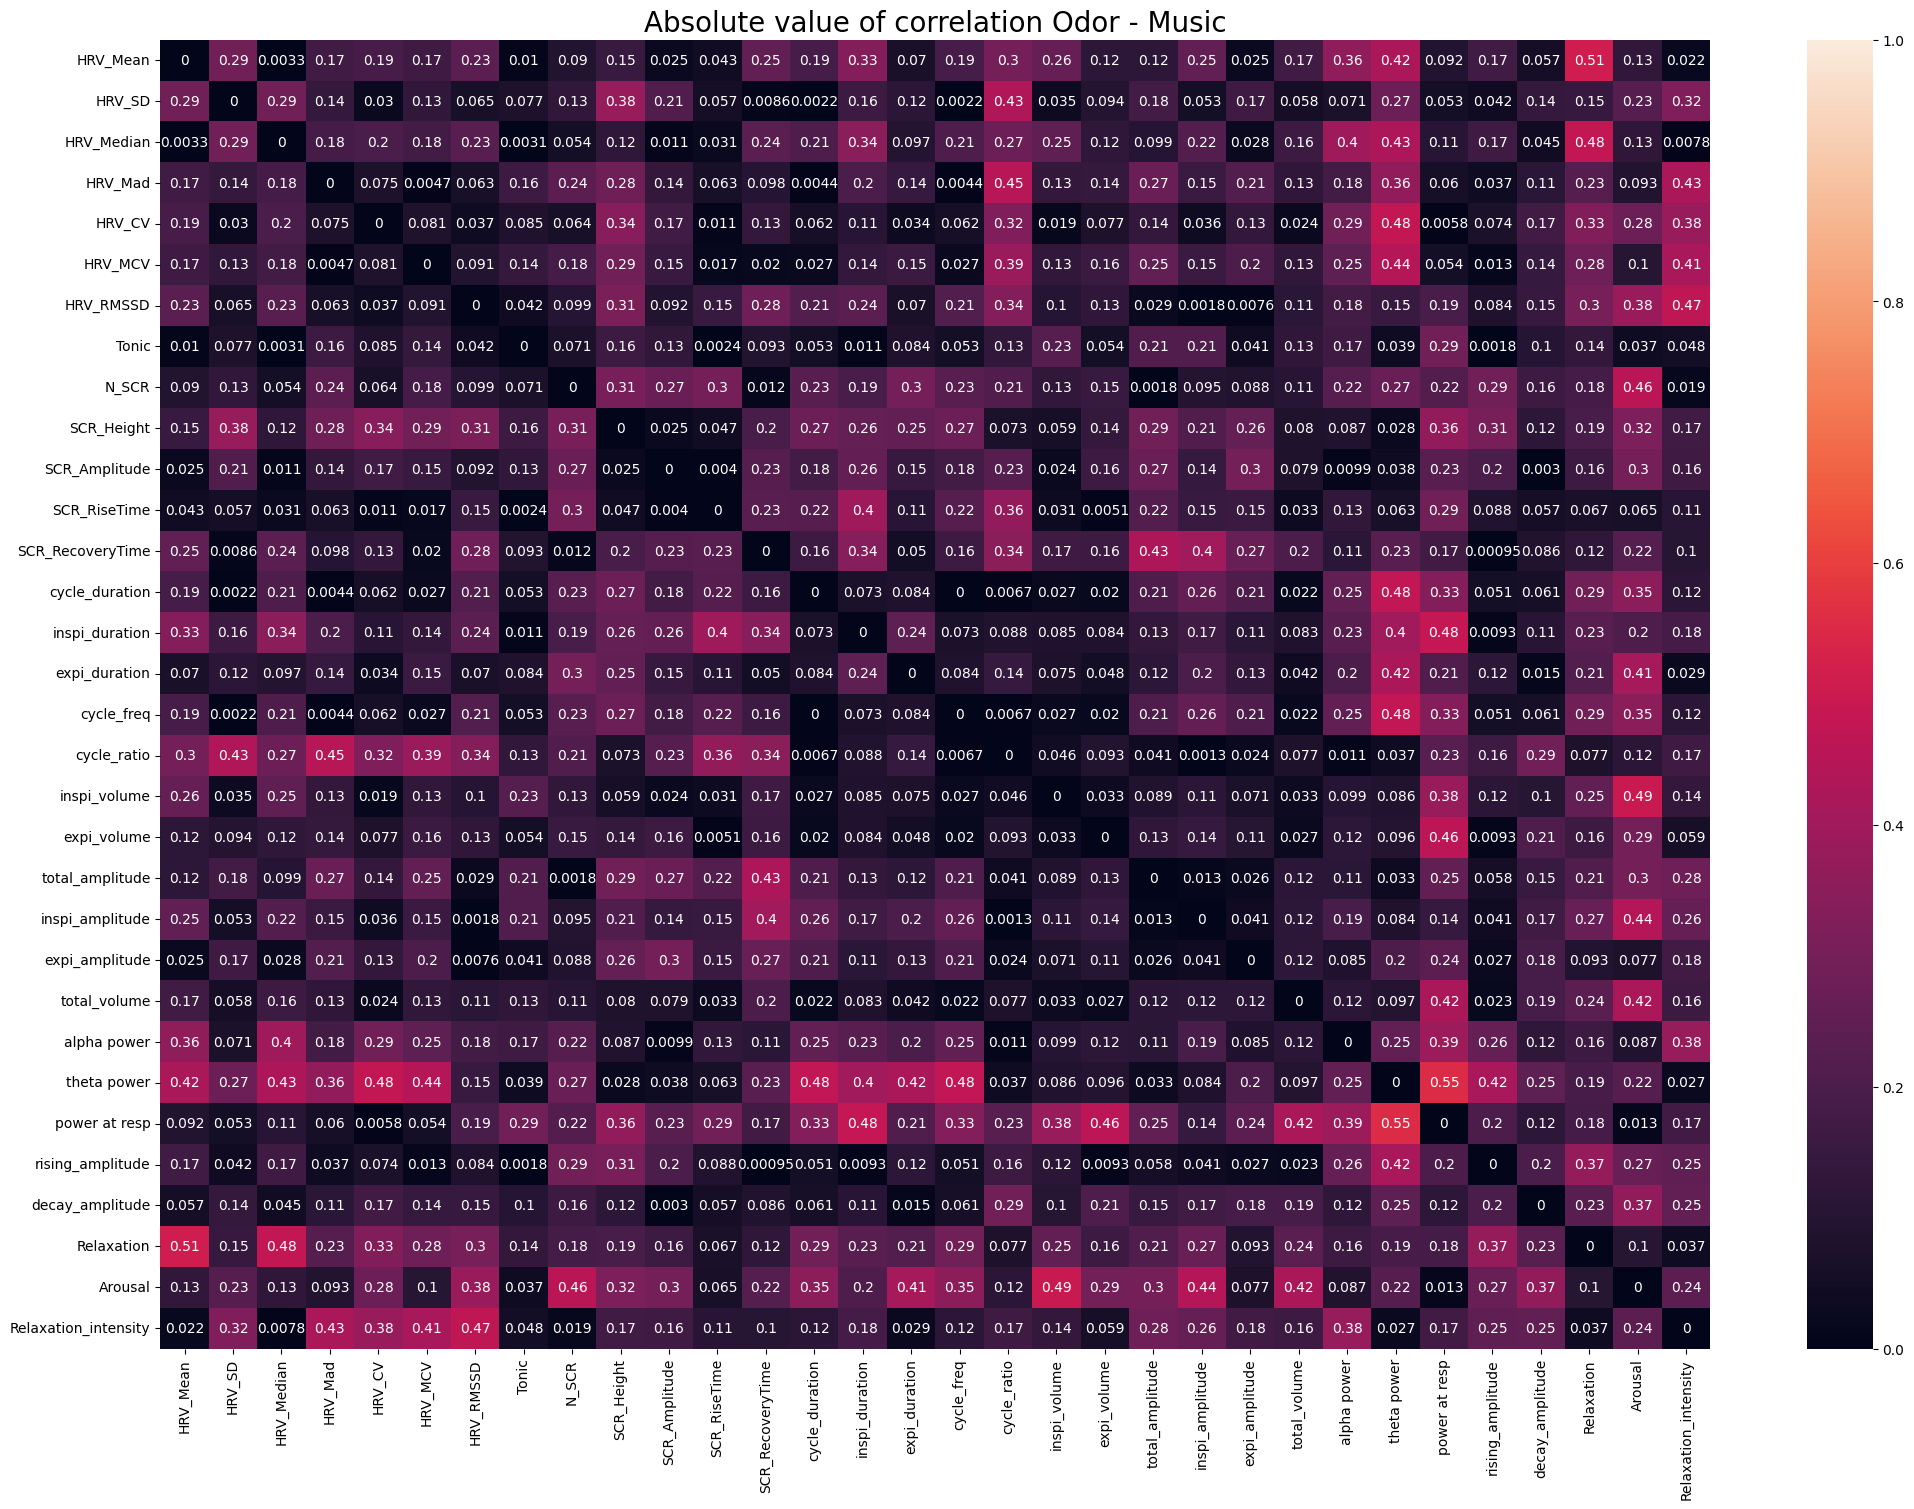

In [26]:
fig, ax = plt.subplots(figsize = (25,17))
sns.heatmap(np.abs(corrs['odor'] - corrs['music']), annot = True, vmin = 0, vmax = 1, ax=ax)
ax.set_title(f'Absolute value of correlation Odor - Music', fontsize = 20)
file = base_folder / 'Figures' /'Correlations' / f'big_correlation_abs_odor_minus_music.png'
fig.savefig(file, bbox_inches = 'tight')

# SELECT FEATURES FOR ARTICLE

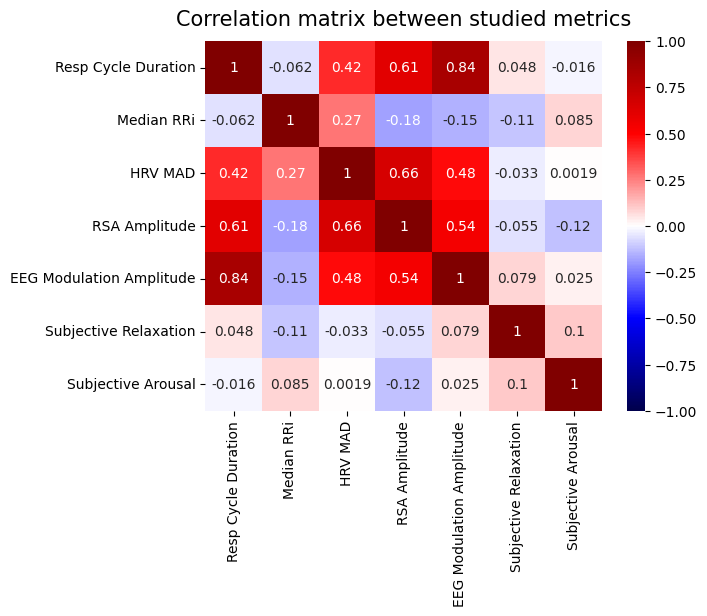

In [27]:
concat = []

for label, df in zip(['hrv','eda','resp','bandpower','power_at_resp','rsa','psycho','modulation'],[hrv, eda, resp, bandpower, power_at_resp, rsa, psycho, modulation]):
    concat.append(df[metrics[label]].reset_index(drop=True))
    
grouping = pd.concat(concat, axis = 1)

metrics_sel = ['cycle_duration','HRV_Median','HRV_Mad','decay_amplitude','amplitude','Relaxation_intensity','Arousal']
df_corr_paper = grouping[metrics_sel]
df_corr_paper.columns = ['Resp Cycle Duration','Median RRi','HRV MAD','RSA Amplitude','EEG Modulation Amplitude','Subjective Relaxation','Subjective Arousal']

fig ,ax = plt.subplots()
sns.heatmap(df_corr_paper.corr('pearson'), annot = True, ax=ax, vmin = -1, vmax = 1, cmap = 'seismic')
ax.set_title('Correlation matrix between studied metrics', fontsize = 15, y = 1.02)

fig.savefig(base_folder / 'Figures' / 'pour_article' / 'corr_matrix.png', dpi = 500, bbox_inches = 'tight')

<AxesSubplot: title={'center': 'Correlation (spearman) : 0.78, R² : 0.705, pval : ****'}, xlabel='Resp Cycle Duration', ylabel='EEG Modulation Amplitude'>

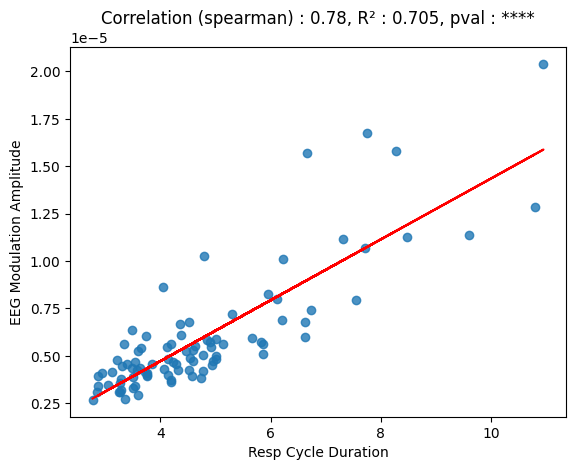

In [29]:
gh.stats_quantitative(df = df_corr_paper, xlabel = 'Resp Cycle Duration', ylabel = 'EEG Modulation Amplitude')

<AxesSubplot: title={'center': 'Correlation (spearman) : 0.576, R² : 0.373, pval : ****'}, xlabel='Resp Cycle Duration', ylabel='RSA Amplitude'>

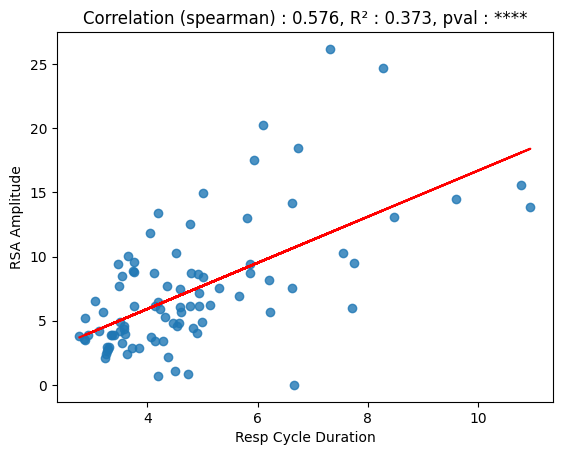

In [30]:
gh.stats_quantitative(df = df_corr_paper, xlabel = 'Resp Cycle Duration', ylabel = 'RSA Amplitude')

<AxesSubplot: title={'center': 'Correlation (spearman) : 0.419, R² : 0.177, pval : ****'}, xlabel='Resp Cycle Duration', ylabel='HRV MAD'>

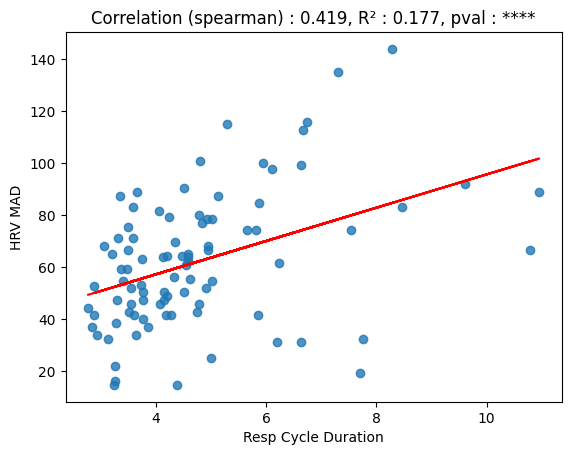

In [31]:
gh.stats_quantitative(df = df_corr_paper, xlabel = 'Resp Cycle Duration', ylabel = 'HRV MAD')